In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches

import os
import math
import random

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.optimize import fsolve

import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [2]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

## GAUSSIAN EXAMPLE

In [3]:
##############
# PARAMETERS #
##############

# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'discovery'

# gaussian, mean
epsilon = 0.3

# dataset, number of events
N = 500000

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = 5000

# S_expected:
S_expected = [50, 200, 400]



# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SsqrtB = [i/(B_expected**0.5) for i in S_expected]

#### Gaussian dim=3 no correlation

In [4]:
dim=3

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_mon = df[['dim1','dim2','dim3']].values 
y_mon = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25

X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)


X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (499999, 3)
y_mon_train :  (499999, 1)
X_mon_val :  (166667, 3)
y_mon_val :  (166667, 1)
X_mon_test :  (333334, 3)
y_mon_test :  (333334, 1)



## Binary Classifier

[0]	validation_0-logloss:0.67557	validation_1-logloss:0.67556


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.66099	validation_1-logloss:0.66102
[2]	validation_0-logloss:0.64875	validation_1-logloss:0.64879
[3]	validation_0-logloss:0.63840	validation_1-logloss:0.63845
[4]	validation_0-logloss:0.62958	validation_1-logloss:0.62958
[5]	validation_0-logloss:0.62212	validation_1-logloss:0.62215
[6]	validation_0-logloss:0.61573	validation_1-logloss:0.61576
[7]	validation_0-logloss:0.61028	validation_1-logloss:0.61035
[8]	validation_0-logloss:0.60553	validation_1-logloss:0.60560
[9]	validation_0-logloss:0.60142	validation_1-logloss:0.60147
[10]	validation_0-logloss:0.59787	validation_1-logloss:0.59792
[11]	validation_0-logloss:0.59481	validation_1-logloss:0.59485
[12]	validation_0-logloss:0.59215	validation_1-logloss:0.59221
[13]	validation_0-logloss:0.58981	validation_1-logloss:0.58986
[14]	validation_0-logloss:0.58778	validation_1-logloss:0.58782
[15]	validation_0-logloss:0.58600	validation_1-logloss:0.58604
[16]	validation_0-logloss:0.58444	validation_1-logloss:0.58449
[

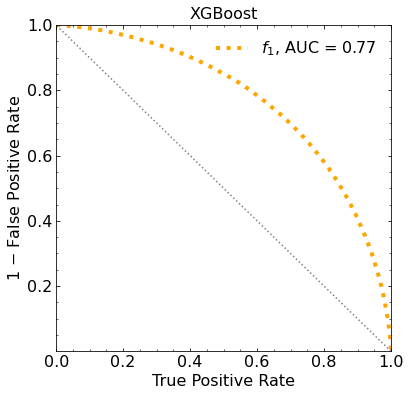

In [5]:
###########
# XGBOOST #
###########

roc_auc_xg, y_pred_xg = XG(X_mon_train, X_mon_test, X_mon_val, 
                           y_mon_train, y_mon_test, y_mon_val, 
                           n_estimators=500)

Classification score:


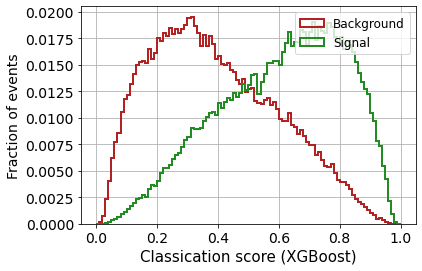

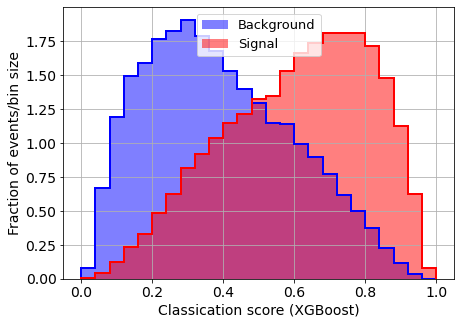

In [6]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
#plt.savefig('images/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()



plt.figure(figsize=(7,5))

nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 25, range=[0,1], density=True, histtype='step', color='blue', linewidth=2)#, label='Background')
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 25, range=[0,1], density=True, histtype='step', color='red', linewidth=2)#, label='Signal')

nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 25, range=[0,1], density=True, color='blue',alpha=0.5, linewidth=2, label='Background')
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 25, range=[0,1], density=True, color='red',alpha=0.5, linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("Classication score (XGBoost)",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)
# plt.title(r'$m(LQ_3^u)=1.2$ TeV, $\beta=0.5$', fontsize=14)
#plt.savefig('XG_output.pdf', format="pdf", bbox_inches="tight")
plt.show()

## BIN LIKELIHOOD

#### Max number of bins

In [7]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  14 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  14
range of our data:  [[0, 1]]


### Z Poisson Bin Likelihood (Asimov data set)

In [8]:
store_Z_asimov = []


for s_it in range(len(S_expected)):

    Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_bins, range_dat, MIN_EVS, linear_bins=True) 
    store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT:\n')
print(store_Z_asimov)


 FINAL RESULT:

[1.1791941688191265, 4.586969530310114, 8.898232573955942]


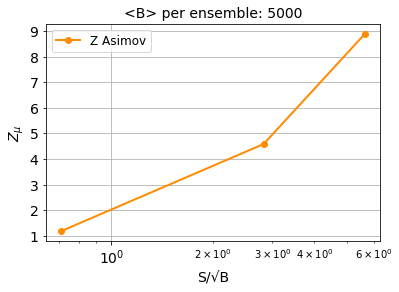

In [9]:
#########
# PLOTS #
#########

plt.figure()
lw = 2

plt.plot(SsqrtB, store_Z_asimov, '-o', color='darkorange', lw=lw, label=r'Z Asimov')  

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### BIN LIKELIHOOD TEST

B_expected:  5000
S_expected:  50

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.191


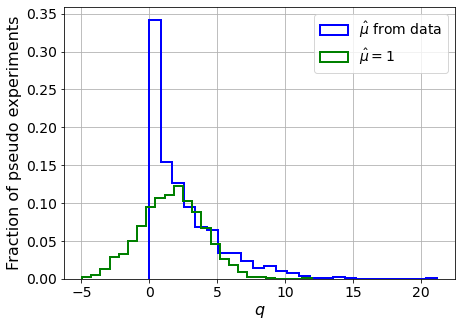

muhat mean:  1.0918726823238567
Z_bins:  1.313863525796472
std Z_bins:  1.013103883048662
Z_bins mu=0:  1.3119724815199882
std Z_bins mu=0:  0.8687037310198827

--------

B_expected:  5000
S_expected:  200

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0295


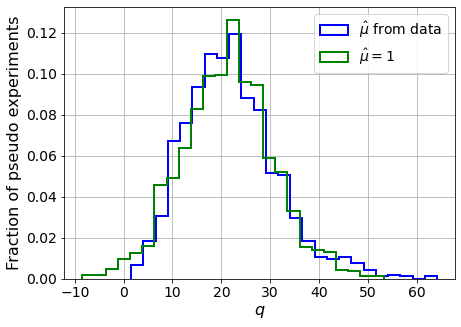

muhat mean:  1.029211746522411
Z_bins:  4.626104160096124
std Z_bins:  1.0192237301041551
Z_bins mu=0:  4.628564771810729
std Z_bins mu=0:  1.0004289658311654

--------

B_expected:  5000
S_expected:  400

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.001


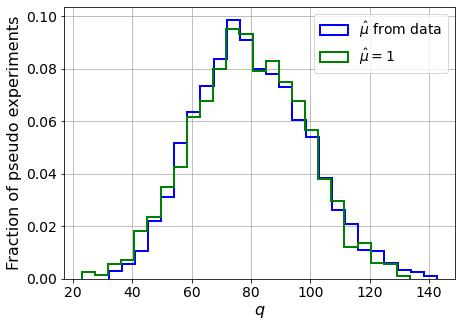

muhat mean:  1.0266766766766768
Z_bins:  8.869419877845589
std Z_bins:  1.055894952287837
Z_bins mu=0:  8.87013613905527
std Z_bins mu=0:  1.0533650122060019

--------


 FINAL RESULT:

[[1.313863525796472, 1.013103883048662, 1.0918726823238567, 1.3119724815199882, 0.8687037310198827], [4.626104160096124, 1.0192237301041551, 1.029211746522411, 4.628564771810729, 1.0004289658311654], [8.869419877845589, 1.055894952287837, 1.0266766766766768, 8.87013613905527, 1.0533650122060019]]


In [10]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

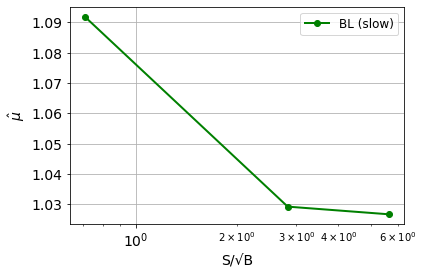

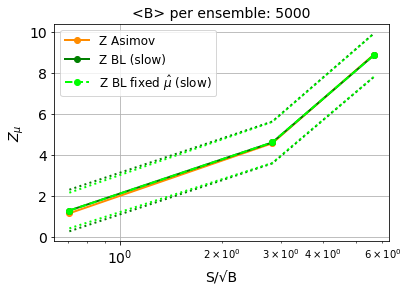

In [11]:
#########
# PLOTS #
#########

# PLOT THE COMPUTED mu_hat 
plt.figure()
lw = 2

plt.plot(SsqrtB,  np.array(store_Z_BL)[:,2], '-o', color='green', lw=lw, label=r'BL (slow)')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(loc="upper right", fontsize=12)
plt.show()




# PLOT THE SIGNIFICANCES
plt.figure()
lw = 2

plt.plot(SsqrtB, store_Z_asimov, '-o', color='darkorange', lw=lw, label=r'Z Asimov')  

plt.plot(SsqrtB, np.array(store_Z_BL)[:,0], '-o', color='green', lw=lw, label=r'Z BL (slow)')
plt.plot(SsqrtB, np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], ':', color='green', lw=lw) 
plt.plot(SsqrtB, np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], ':', color='green', lw=lw)

plt.plot(SsqrtB, np.array(store_Z_BL)[:,3], '--o', color='lime', lw=lw, label=r'Z BL fixed $\hat{\mu}$ (slow)')
plt.plot(SsqrtB, np.array(store_Z_BL)[:,3] + np.array(store_Z_BL)[:,4], ':', color='lime', lw=lw) 
plt.plot(SsqrtB, np.array(store_Z_BL)[:,3] - np.array(store_Z_BL)[:,4], ':', color='lime', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

## MLL+KDE

### KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   964.52071791   966.6476352    969.71005516   968.82863805
   965.5906498    955.72198619   929.54238311   860.69023274
   700.03608849   331.7579302   -454.44381834 -1889.90457597]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf


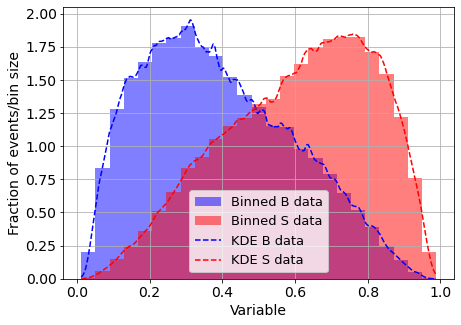

KDE Kernel:  epanechnikov
Background bandwidth:  0.013538761800225447
Signal bandwidth:  0.022117541055781564


In [12]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, 
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

#### Evaluate the PDFs with the classifier output

In [13]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP


if D_or_E == "discovery":

    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
else:
    # dummies
    pB_S_data = 1
    pS_S_data = 1

This may take a while...
1 done
2 done
3 done
4 done


### MLL+KDE test

B_expected:  5000
S_expected:  50



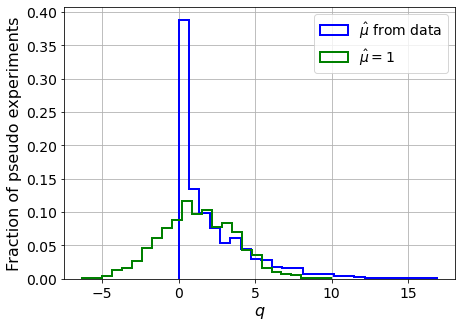

muhat mean:  0.956825
Z_bins:  1.107899470444716
std Z_bins:  1.1729321016620382
Z_bins mu=0:  1.1101108153098744
std Z_bins mu=0:  1.0971174076569872

--------

B_expected:  5000
S_expected:  200



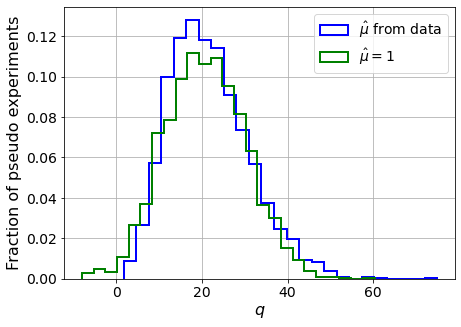

muhat mean:  1.005225
Z_bins:  4.545162758348253
std Z_bins:  1.036930214943917
Z_bins mu=0:  4.545503794637671
std Z_bins mu=0:  1.0417093979485594

--------

B_expected:  5000
S_expected:  400



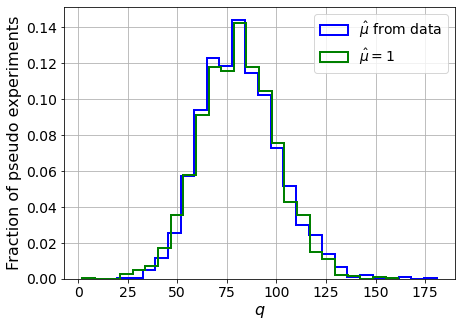

muhat mean:  1.02445
Z_bins:  8.983539252091434
std Z_bins:  1.0740823578298686
Z_bins mu=0:  8.985051903139713
std Z_bins mu=0:  1.069939817633235

--------


 FINAL RESULT:

[[1.107899470444716, 1.1729321016620382, 0.956825, 1.1101108153098744, 1.0971174076569872], [4.545162758348253, 1.036930214943917, 1.005225, 4.545503794637671, 1.0417093979485594], [8.983539252091434, 1.0740823578298686, 1.02445, 8.985051903139713, 1.069939817633235]]
[[1.107899470444716, 1.1729321016620382, 0.956825, 1.1101108153098744, 1.0971174076569872], [4.545162758348253, 1.036930214943917, 1.005225, 4.545503794637671, 1.0417093979485594], [8.983539252091434, 1.0740823578298686, 1.02445, 8.985051903139713, 1.069939817633235]]


In [14]:
# OPTION 1 (faster)
store_Z_MLL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected[s_it], num_pseudo)
    
    store_Z_MLL.append( list(Z_MLL) )
    
    print('muhat mean: ', Z_MLL[2])
    print('Z_bins: ', Z_MLL[0])
    print('std Z_bins: ', Z_MLL[1])
    print('Z_bins mu=0: ', Z_MLL[3])
    print('std Z_bins mu=0: ', Z_MLL[4])
    print('')
    print('--------\n')
    
    
print('\n FINAL RESULT:\n')
print(store_Z_MLL)
print(store_Z_MLL)

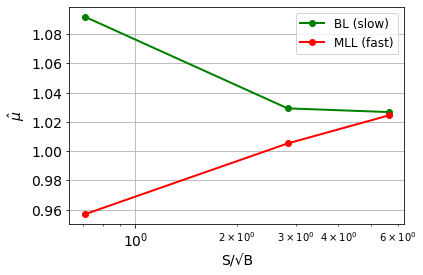

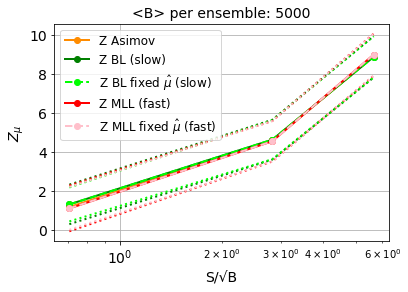

In [15]:
#########
# PLOTS #
#########

# PLOT THE COMPUTED mu_hat 
plt.figure()
lw = 2

plt.plot(SsqrtB,  np.array(store_Z_BL)[:,2], '-o', color='green', lw=lw, label=r'BL (slow)')

plt.plot(SsqrtB,  np.array(store_Z_MLL)[:,2], '-o', color='red', lw=lw, label=r'MLL (fast)')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(loc="upper right", fontsize=12)
plt.show()




# PLOT THE SIGNIFICANCES
plt.figure()
lw = 2

plt.plot(SsqrtB, store_Z_asimov, '-o', color='darkorange', lw=lw, label=r'Z Asimov')  

plt.plot(SsqrtB, np.array(store_Z_BL)[:,0], '-o', color='green', lw=lw, label=r'Z BL (slow)')
plt.plot(SsqrtB, np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], ':', color='green', lw=lw) 
plt.plot(SsqrtB, np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], ':', color='green', lw=lw)

plt.plot(SsqrtB, np.array(store_Z_BL)[:,3], '--o', color='lime', lw=lw, label=r'Z BL fixed $\hat{\mu}$ (slow)')
plt.plot(SsqrtB, np.array(store_Z_BL)[:,3] + np.array(store_Z_BL)[:,4], ':', color='lime', lw=lw) 
plt.plot(SsqrtB, np.array(store_Z_BL)[:,3] - np.array(store_Z_BL)[:,4], ':', color='lime', lw=lw)

plt.plot(SsqrtB, np.array(store_Z_MLL)[:,0], '-o', color='red', lw=lw, label=r'Z MLL (fast)')
plt.plot(SsqrtB, np.array(store_Z_MLL)[:,0] + np.array(store_Z_MLL)[:,1], ':', color='red', lw=lw) 
plt.plot(SsqrtB, np.array(store_Z_MLL)[:,0] - np.array(store_Z_MLL)[:,1], ':', color='red', lw=lw)

plt.plot(SsqrtB, np.array(store_Z_MLL)[:,3], '--o', color='pink', lw=lw, label=r'Z MLL fixed $\hat{\mu}$ (fast)')
plt.plot(SsqrtB, np.array(store_Z_MLL)[:,3] + np.array(store_Z_MLL)[:,4], ':', color='pink', lw=lw) 
plt.plot(SsqrtB, np.array(store_Z_MLL)[:,3] - np.array(store_Z_MLL)[:,4], ':', color='pink', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()